#  Medical Image Segmenation 

##  "Simple Thresholding Technique" 

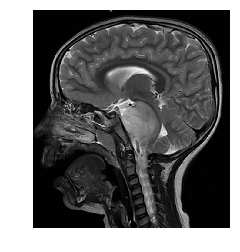

In [69]:
# First import OpenCV, NumPY and MatPlotLib as we will use these libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Load a color image
img = cv2.imread("brainscan.jpg")

#Original Image
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Blurring Image To Reduce Noise

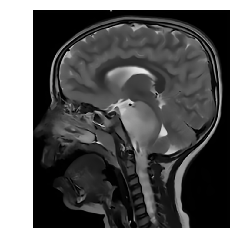

In [71]:
# Apply some blurring to reduce noise

# h is the Parameter regulating filter strength for luminance component. 
# Bigger h value perfectly removes noise but also removes image details, 
# smaller h value preserves details but also preserves some noise
# Experiment with setting h and hColor to a suitable value.

h = 20
hColor = 20 
    
# Default values
templateWindowSize = 7
searchWindowSize = 21
    
blur = cv2.fastNlMeansDenoisingColored(img, None,h,hColor,templateWindowSize,searchWindowSize)
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.savefig("blur.jpg")

# Edge Detection

Now, lets run a morphological operation on the blurred image.  

For this example, we are going to generate a gradient.  



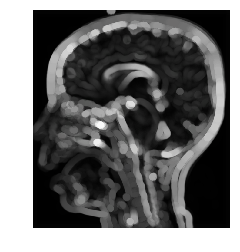

In [72]:
# Apply a morphological gradient (dilate the image, erode the image, and take the difference)

elKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (23,23))

# YOUR CODE HERE
gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, elKernel)
# END YOUR CODE HERE

plt.imshow(cv2.cvtColor(gradient, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.savefig("edgedetect.jpg")

We now have completed the pre-processing of our image. 

From this point onwards, we are concerning ourselves with:

a) filling the region of interest, and

b) removing artefacts from the image which we are not interested in.

There are quite a few approaches we can take to this (including not doing them at all), but today lets apply OTSU's threshold to convert the image to black and white, and perform a closing operation to 'fill in' the starfish and then perform some erosion to remove parts of the image that we consider noise.

This builds on dilation and erosion.  You can read more about erosion and dilation 
in the 'Basics' section of Lesson 2.

Today we are going to use them to generate an outline for our street sign.

After applying the gradient morphology routine above, you should end up with an image similar to the one shown here.  The outline of the starfish should be starting to emerge at this point.

## OTSU Thresholding

- When converting from a grayscale image to a black and white image, selecting a good threshold value can be a time-consuming and manual process.  

- There are a number of automatic thresholding techniques available and Otsu's method thresholding is one of the better known techniques.

- Conceptually simple, and relatively low cost computationally, Otsu's threshold iterate through all the possible threshold values to find the threshold value where the sum of foreground and background spreads is at its minimum. 


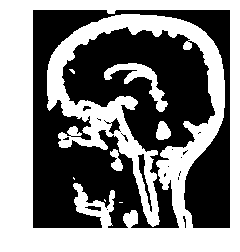

In [73]:
# Apply Otsu's method - or you can adjust the level at which thresholding occurs
# and see what the effect of this is
# Convert gradient to grayscale

gradient = cv2.cvtColor(gradient, cv2.COLOR_BGR2GRAY)

#Apply Otsu's method for thresholding gradient image
otsu = cv2.threshold(gradient, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

plt.imshow(otsu, cmap='gray')
plt.axis("off")
plt.savefig("otsu.jpg")       

# Closing Operation

(-0.5, 649.5, 719.5, -0.5)

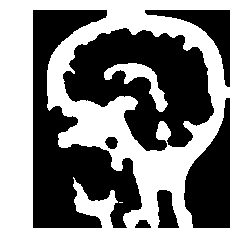

In [62]:
# Apply a closing operation - we're using a large kernel here. By all means adjust the size of this kernel
# and observe the effects

closingKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (33,33))
close = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, closingKernel)
plt.imshow(close, cmap='gray')
plt.axis("off")

# Erosion Operation

(-0.5, 649.5, 719.5, -0.5)

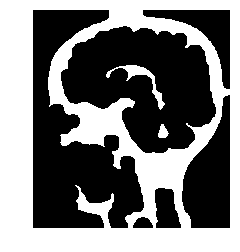

In [77]:
# Erode smaller artefacts out of the image - play with iterations to see how it works
#Erosion Operations

eroded = cv2.erode(close, None, iterations=6) 
plt.imshow(eroded, cmap='gray')
plt.savefig("erosion.jpg")
plt.axis("off")

So, now we've effectively segmented our image. 

Now, let's post-process the image to find the contours that represent the edge of the street sign.  We'll just use the intuition that the street sign is the largest object in the scene.

Then we'lll do a little image manipulation to generate a colour representing the street sign, another colour representing the background (i.e. not the street sign) and then merge those colours with the original image.

You'll notice the closing and erosion steps are not perfect - they're not supposed to be.  They are good enough to feed into the findContours routine.  By all means, tune them further to get better quality input into findContours.

In the findContours routine we're using cv2.RETR_EXTERNAL.  This is to reduce the complexity of post-processing by only reporting 'external' contours (i.e. we'll attempt to suppress contours that are inside other contours).

In [64]:
p = int(img.shape[1] * 0.05)
eroded[:, 0:p] = 0
eroded[:, img.shape[1] - p:] = 0


(-0.5, 649.5, 719.5, -0.5)

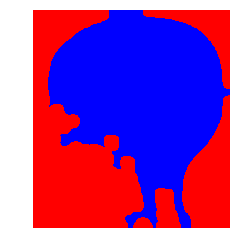

In [75]:
# keep post-processing simple
# Find Contours on Erosion Image

(cnting, contours, _) = cv2.findContours(eroded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


# Sort the candidates by size, and just keep the largest one
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

# Lets create two images, initially all zeros (i.e. black)
# One image will be filled with 'Blue' wherever we think there's some starfish
# The other image will be filled with 'Green' whereever we think there's not some starfish
h, w, num_c = img.shape
segmask = np.zeros((h, w, num_c), np.uint8)
stencil = np.zeros((h, w, num_c), np.uint8)

# I know we've only one contour, but - in general - we'd expect to have more contours to deal with
for c in contours:
    # Fill in the starfish shape into segmask
    cv2.drawContours(segmask, [c], 0, (255,0,0), -1)
    # Lets fill in the starfish shape into stencil as well
    # and then re-arrange the colors using numpy
    cv2.drawContours(stencil, [c], 0, (255, 0, 0), -1)
    stencil[np.where((stencil==[0,0,0]).all(axis=2))] = [0,0, 255]
    stencil[np.where((stencil==[255,0,0]).all(axis=2))] = [0, 0, 0]

# Now, lets create a mask image by bitwise ORring segmask and stencil together
mask = cv2.bitwise_or(stencil, segmask)

plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.axis("off")


- You should have generated a reasonable mask representing our image as having two parts - a 'street sign' and 'not street sign'.  It should look like the final mask in the image below.
    


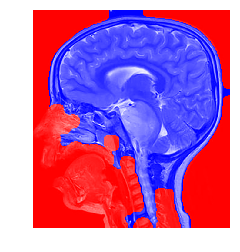

In [76]:
# Now, lets just blend our original image with our mask

output = cv2.bitwise_or(mask, img)

plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.savefig("segment.jpg")

# Conclusion

  
To summarise , we''ve learned some basic image processing techniques, such as morphological operations like erosion and dilation, contour detection and we've used these techniques in combination with Otsu's thresholding method to segment an image.


**Solution for Our First Segmenter Missing Code:**

    hColor = h = 20

**Solution for Edge Detection Missing Code:**

    gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, elKernel)

**Solution for OTSU Thresholding:**

    otsu = cv2.threshold(gradient, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

**Solution for Erode Smaller Artefacts Missing Code:**

    eroded = cv2.erode(close, None, iterations=6)

**Solution for Find the Contours Missing Code:**

    (cnting, contours, _) = cv2.findContours(eroded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

**Solution for Blending Original Image with Mask Missing Code:**

    output = cv2.bitwise_or(mask, img)
    
**Credit Course : Microsoft ComputerVision**